# Imports:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import chi2

from tqdm import tqdm, trange
import random

import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from scipy.special import expit, logit

# Hyperparameters:

In [24]:
pop_size = 100 * 1_000
sample_size = 30
agg_iters = 100_0

normal_stdev = 100

beta = 1

## for biased sampling mechanism:
sample_probability_centering = 0.8
sample_probability_bias_factor = 10
sample_probability_bias_factor_x = 10

In [25]:
## for rng generator:
pop_number = 1

# Run:

In [26]:
rand_generator = np.random.default_rng(seed=333 * pop_number)

In [27]:
assert pop_size % 100 == 0
base_x = [i for i in range(-50, 0)] + [i for i in range(1, 51)]
x = pd.Series(base_x * (pop_size // 100))

In [28]:
std_x = np.std(x)
std_x_abs = np.std(x.abs())

In [29]:
fitted_betas = []
fitted_FI = []
fitted_correlations = []
realized_sample_sizes = []

Create the simulated data (x, y):

In [30]:
y = x * beta + rand_generator.normal(size=pop_size) * normal_stdev

In [31]:
std_y = np.sqrt(np.var(x) + normal_stdev ** 2)

In [32]:
np.std(y)

104.65955641791805

In [33]:
data = pd.concat([y, x], axis=1)

data.columns = ['y', 'x']

fitted_beta = sm.OLS(data['y'], data['x']).fit().params.iloc[0]

sm.OLS(data['y'], data['x']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.079
Model:                            OLS   Adj. R-squared (uncentered):              0.079
Method:                 Least Squares   F-statistic:                              8532.
Date:                Tue, 31 Dec 2024   Prob (F-statistic):                        0.00
Time:                        12:20:47   Log-Likelihood:                     -6.0287e+05
No. Observations:              100000   AIC:                                  1.206e+06
Df Residuals:                   99999   BIC:                                  1.206e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.0015      0.011     92.370      0.000       0.980       1.023
==============================================================================
Omnibus:                        6.615   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                6.474
Skew:                           0.008   Prob(JB):                       0.0393
Kurtosis:                       2.964   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
data['g_star'] = data['x'] * (data['y'] - data['x'] * fitted_beta)

In [35]:
marginal_probabilities = expit(logit(sample_probability_centering) + \
       sample_probability_bias_factor * (y / std_y) + \
       sample_probability_bias_factor_x * (data['x'].abs() - 25.5) / std_x_abs)

In [36]:
np.mean(marginal_probabilities)

0.5314348843229589

# run:

In [37]:
for _ in tqdm(range(agg_iters)):
    srs_sample_indices = pd.Series(random.sample(range(pop_size), sample_size))
    srs_sample_indices = srs_sample_indices.sort_values().reset_index(drop=True)

    # reset the sample
    data['r0'] = 0
    data['r'] = 0
    data['r1'] = 0
    data['r2'] = 0
    
    data.loc[srs_sample_indices, 'r0'] = 1
    full_sampled_data = data[data['r0'] == 1]

    # marginal_probabilities = expit(logit(sample_probability_centering) + \
    #                                sample_probability_bias_factor * (full_sampled_data['x'].abs() - 25.5))
    biased_sample_indices = marginal_probabilities.index[rand_generator.binomial(n=1, p = marginal_probabilities) == 1]

    data.loc[biased_sample_indices, 'r'] = 1

    biased_sample_indices_size = len(biased_sample_indices)
    realized_sample_sizes.append(biased_sample_indices_size)


    srs_sample = data[data['r0'] == 1].copy()
    biased_sample = data[data['r'] == 1].copy()

    srs_fitted_beta = sm.OLS(srs_sample['y'], srs_sample['x']).fit().params.iloc[0]
    biased_fitted_beta = sm.OLS(biased_sample['y'], biased_sample['x']).fit().params.iloc[0]

    fitted_betas.append(pd.Series([fitted_beta, srs_fitted_beta, biased_fitted_beta]))

    fitted_FI.append(pd.Series([np.mean(srs_sample['x'] ** 2), np.mean(biased_sample['x'] ** 2)]))

    fitted_correlations.append(data[['g_star', 'r0', 'r']].corr().iloc[0, 1:])

100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.39it/s]


Clean up the data:

In [38]:
fitted_betas = pd.concat(fitted_betas, axis=1).T
fitted_FI = pd.concat(fitted_FI, axis=1).T
fitted_correlations = pd.concat(fitted_correlations, axis=1).T.reset_index(drop=True)

In [39]:
fitted_FI.columns = ['srs', 'biased']
fitted_betas.columns = ['population', 'srs', 'biased']
fitted_correlations.columns = ['srs', 'biased']

In [40]:
realized_sample_sizes = pd.Series(realized_sample_sizes)

# Plot:

In [41]:
fitted_FI_and_corr = fitted_FI.join(fitted_correlations, lsuffix = '_fi', rsuffix = '_corr')

fitted_FI_and_corr.head()

,srs_fi,biased_fi,srs_corr,biased_corr
0,1046.433333,1272.087409,-0.000045,-0.082717
1,734.866667,1271.911568,-0.001547,-0.081931
2,1239.766667,1272.687422,0.005445,-0.082086
3,791.300000,1272.875249,0.003470,-0.081926
4,1107.400000,1272.260527,0.000877,-0.082947


In [42]:
Jeee = np.mean(data['x'] ** 2)

fitted_FI_and_corr['srs_samp_elasticity'] = fitted_FI_and_corr.eval(f'srs_fi / {Jeee}')
fitted_FI_and_corr['biased_samp_elasticity'] = fitted_FI_and_corr.eval(f'biased_fi / {Jeee}')

Text(0.5, 0.01, 'Jn (across sampling mechanisms)')

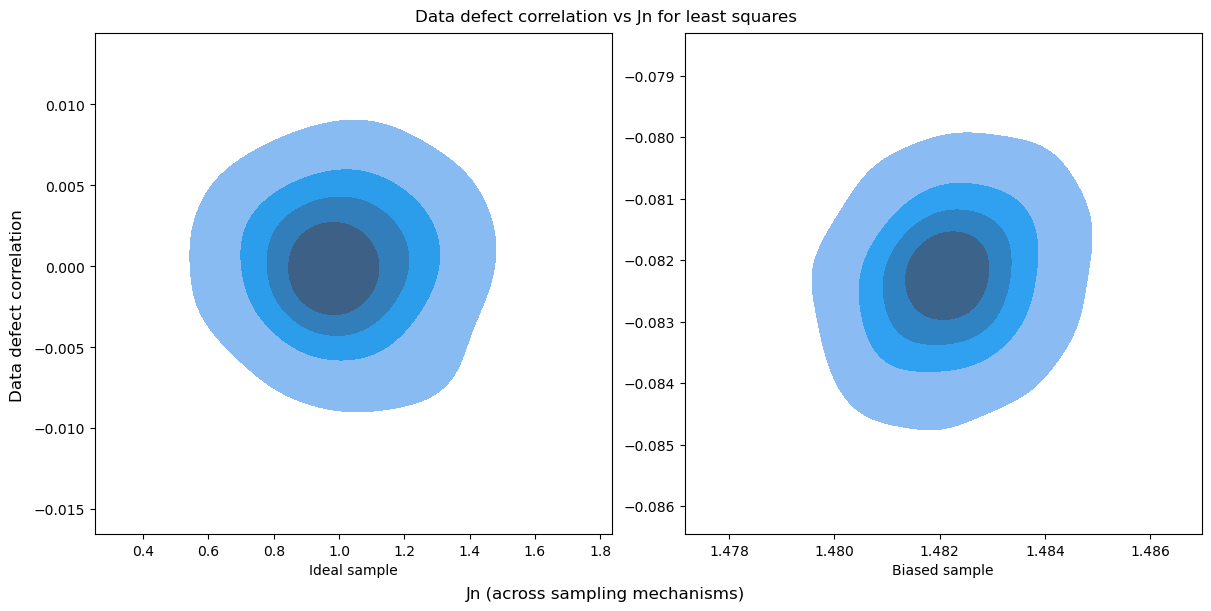

In [43]:
fig, axes = plt.subplots(1, 2, 
                         constrained_layout=True, 
                         figsize=(12, 6))

ax = axes[0]
sns.kdeplot(data = fitted_FI_and_corr, 
            x=f'srs_samp_elasticity',
            y = f'srs_corr', 
            fill=True, 
            bw_adjust=1.8, 
            levels=5,
            ax=ax
           )
ax.set_xlabel('Ideal sample')
ax.set_ylabel('')

ax = axes[1]
sns.kdeplot(data = fitted_FI_and_corr, 
            x=f'biased_samp_elasticity',
            y = f'biased_corr', 
            fill=True, 
            bw_adjust=1.8, 
            levels=5,
            ax=ax
           )
ax.set_xlabel('Biased sample')
ax.set_ylabel('')

fig.suptitle('Data defect correlation vs Jn for least squares')
fig.supylabel('Data defect correlation')
fig.supxlabel('Jn (across sampling mechanisms)')

In [44]:
fitted_FI_and_corr['const'] = 1

In [45]:
for samp_scheme in ['srs', 'biased']:
    print(sm.OLS(endog = fitted_FI_and_corr[f'{samp_scheme}_corr'], 
           exog = fitted_FI_and_corr[['const', f'{samp_scheme}_samp_elasticity']]
          ).fit().summary()
    )

                            OLS Regression Results                            
Dep. Variable:               srs_corr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3725
Date:                Tue, 31 Dec 2024   Prob (F-statistic):              0.542
Time:                        12:21:11   Log-Likelihood:                 4322.1
No. Observations:                1000   AIC:                            -8640.
Df Residuals:                     998   BIC:                            -8630.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0004    